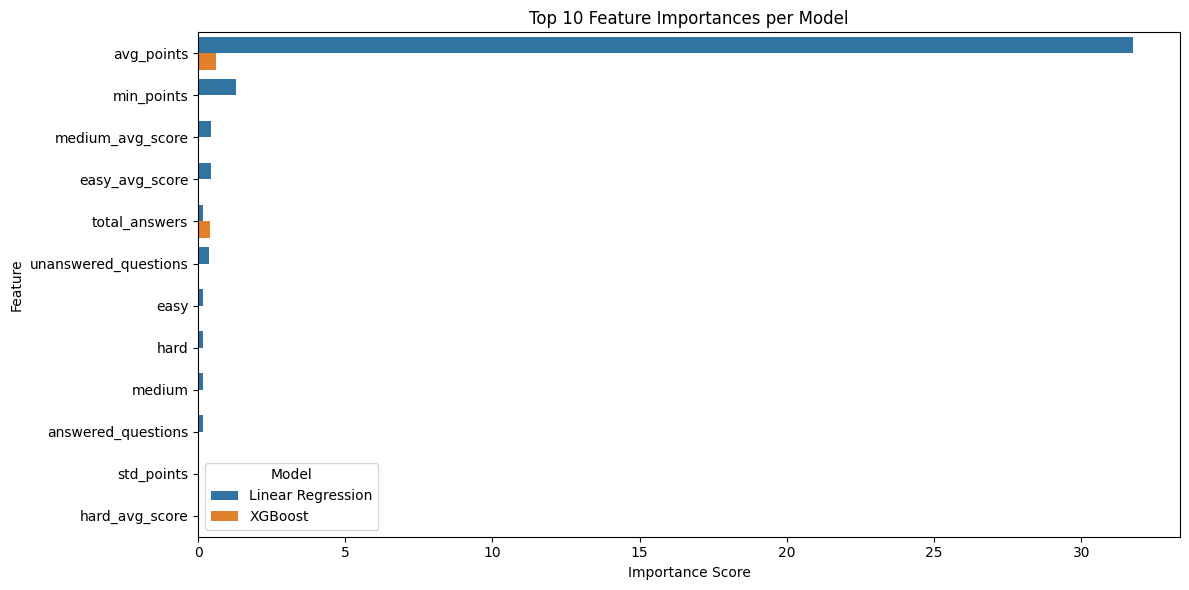

In [7]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# 📥 Load and Prepare Data
df = pd.read_csv("../data/processed/updated_data_with_points.csv")

# 🎯 Feature Engineering (per student)
student_features = df.groupby("Student_Id").agg(
    total_answers=("Answer", "count"),
    answered_questions=("Answer", lambda x: x.notnull().sum()),
    unanswered_questions=("Answer", lambda x: x.isnull().sum()),
    avg_points=("Assigned Points", "mean"),
    max_points=("Assigned Points", "max"),
    min_points=("Assigned Points", "min"),
    std_points=("Assigned Points", "std")
).reset_index()

difficulty_counts = df.pivot_table(index="Student_Id", columns="Difficulty", 
                                   values="Question", aggfunc="count", fill_value=0).reset_index()

difficulty_scores = df.pivot_table(index="Student_Id", columns="Difficulty", 
                                   values="Assigned Points", aggfunc="mean", fill_value=0).reset_index()

features = student_features.merge(difficulty_counts, on="Student_Id", suffixes=('', '_count'))
features = features.merge(difficulty_scores, on="Student_Id", suffixes=('', '_avg_score'))

student_scores = df.groupby("Student_Id")["Assigned Points"].sum().reset_index()
student_scores.columns = ["Student_Id", "Total Score"]

data = features.merge(student_scores, on="Student_Id")

# 🧪 Prepare X and y
X = data.drop(columns=["Student_Id", "Total Score"])
y = data["Total Score"]

# 🧼 Handle NaNs
imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# ✂️ Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🤖 Train Models
lr_model = LinearRegression().fit(X_train, y_train)
xgb_model = XGBRegressor(random_state=42, verbosity=0).fit(X_train, y_train)

# 📊 Extract Importances
lr_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": np.abs(lr_model.coef_),
    "Model": "Linear Regression"
})

xgb_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_,
    "Model": "XGBoost"
})

# 📚 Combine and Select Top
importances = pd.concat([lr_importance, xgb_importance])
top10_per_model = importances.sort_values(by="Importance", ascending=False).groupby("Model").head(10)

# 🎨 Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top10_per_model, x="Importance", y="Feature", hue="Model")
plt.title("Top 10 Feature Importances per Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
